In [6]:
#! pip install ipympl
%matplotlib ipympl
import torch
import numpy as np
import os
import onnx
import onnxruntime

from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import time

import torch.nn as nn
import torch.optim as optim


In [7]:
# Set device
torch_device = torch.device("cpu")
if torch.backends.mps.is_available():
    torch_device = torch.device("mps")
if torch.cuda.is_available():
    torch_device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True


In [8]:
# Load dataset and plotting utils
%run plotting.ipynb
%run data.ipynb


Plotting loaded
Dataset class loaded


In [9]:
# Normalize Data
img_norm_mean = (0.5, 0.5, 0.5)
img_norm_std = (0.5, 0.5, 0.5)

train_tr = PokemonDataset(dataset_save="raw_data/pokemon_data.pt", raw_data="raw_data/pokemon_images", convert=True, size=32,
                          transform=transforms.Compose([
                              transforms.Normalize(img_norm_mean, img_norm_std)
                          ]))

test_tr = PokemonDataset(dataset_save="raw_data/pokemon_data.pt", raw_data="raw_data/pokemon_images", train=False, convert=True, size=32,
                         transform=transforms.Compose([
                             transforms.Normalize(img_norm_mean, img_norm_std)
                         ]))



In [10]:
# Create DataLoaders
batch_size = 80
train_dl = torch.utils.data.DataLoader(train_tr, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_tr, batch_size=len(test_tr), shuffle=False)

In [11]:
# Load Model
%run model.ipynb

Model setup complete


Training epoch 1 of 200
loss= 1.0997737646102905, accuracy= 0.3152777850627899
Training epoch 2 of 200
loss= 1.0986695686976116, accuracy= 0.3282051384449005
Training epoch 3 of 200
loss= 1.099364201227824, accuracy= 0.3115384578704834
Training epoch 4 of 200
loss= 1.0989068349202473, accuracy= 0.28119657933712006
Training epoch 5 of 200
loss= 1.0966610511144002, accuracy= 0.3615384598573049
Training epoch 6 of 200
loss= 1.098093867301941, accuracy= 0.3693376084168752
Training epoch 7 of 200
loss= 1.0974225203196208, accuracy= 0.3658119738101959
Training epoch 8 of 200
loss= 1.096340537071228, accuracy= 0.37863248586654663
Training epoch 9 of 200
loss= 1.097271998723348, accuracy= 0.39102564255396527
Training epoch 10 of 200
loss= 1.0961148341496785, accuracy= 0.40726495782534283
Training epoch 11 of 200
loss= 1.094854195912679, accuracy= 0.38621795177459717
Training epoch 12 of 200
loss= 1.0949694315592449, accuracy= 0.3661324878533681
Training epoch 13 of 200
loss= 1.0941828886667888

loss= 0.7972227533658346, accuracy= 0.7311965823173523
Training epoch 105 of 200
loss= 0.7843693892161051, accuracy= 0.7354700764020284
Training epoch 106 of 200
loss= 0.7778764565785726, accuracy= 0.7314102649688721
Training epoch 107 of 200
loss= 0.7646782994270325, accuracy= 0.7395299077033997
Training epoch 108 of 200
loss= 0.7548956076304117, accuracy= 0.7436965902646383
Training epoch 109 of 200
loss= 0.7432512839635214, accuracy= 0.7773504058519999
Training epoch 110 of 200
loss= 0.7308732271194458, accuracy= 0.7646367351214091
Training epoch 111 of 200
loss= 0.7218977610270182, accuracy= 0.7770299116770426
Training epoch 112 of 200
loss= 0.7150598168373108, accuracy= 0.768910268942515
Training epoch 113 of 200
loss= 0.6868803103764852, accuracy= 0.8238247831662496
Training epoch 114 of 200
loss= 0.6755721966425577, accuracy= 0.8074786265691122
Training epoch 115 of 200
loss= 0.671811580657959, accuracy= 0.8065170844395956
Training epoch 116 of 200
loss= 0.6665012240409851, accu

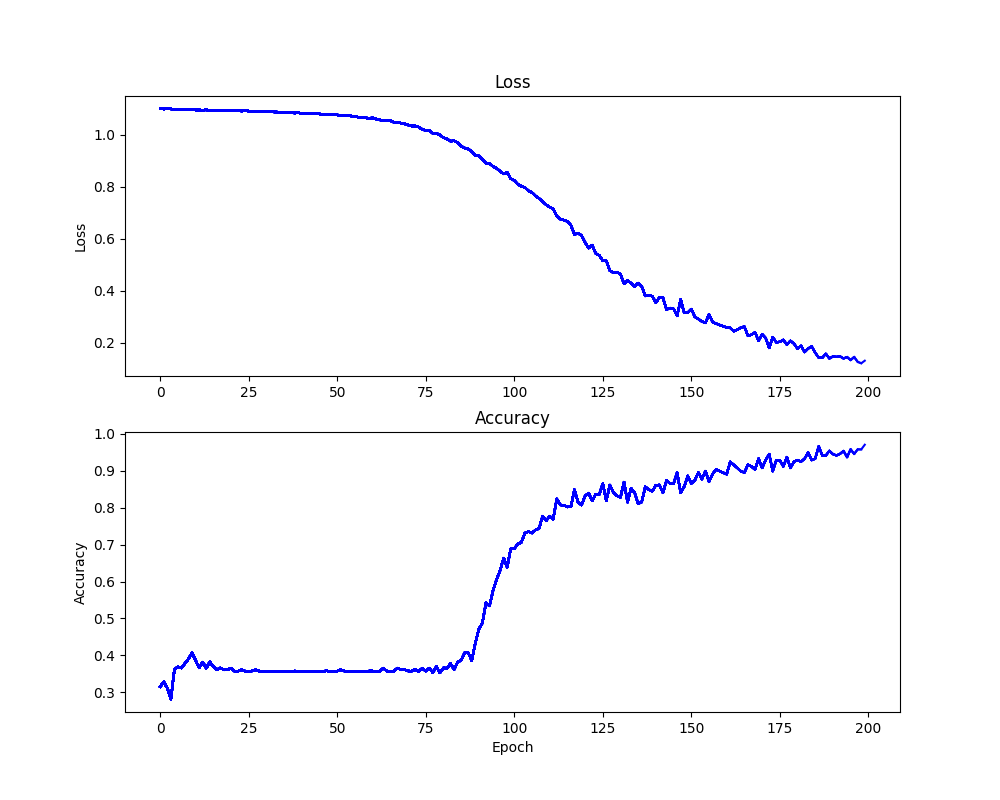

In [12]:
%%time

fig, ax = start_plot()
CNN = Classifier_CNN()
CNN.to(torch_device)

epochs = 200
loss_hist = []
accuracy_hist = []

for i in range(epochs):
    loss = 0
    accuracy = 0
    print(f"Training epoch {i+1} of {epochs}")
    for _, data in enumerate(train_dl, 0):
        images_data = data[0].to(torch_device)
        labels = data[1].to(torch_device)

        iter_loss, iter_acc = CNN.run_training(images_data, labels)
        loss += iter_loss
        accuracy += iter_acc

    loss /= len(train_dl)
    accuracy /= len(train_dl)
    loss_hist.append(loss)
    accuracy_hist.append(accuracy)
    print(f"loss= {loss}, accuracy= {accuracy}")
    with plt.ioff():
        ax[0].plot(loss_hist, color='blue', label='train')
        ax[1].plot(accuracy_hist, color='blue', label='train')
        fig.canvas.draw()


In [13]:
# Evaluate
CNN.model.eval()

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-mesure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))

with torch.no_grad():
    for imgs, labels in test_dl:
        outputs = CNN.forward(imgs.to(torch_device))
        _, preds = torch.max(outputs, dim=1)
        print_metrics_function(labels, preds.cpu())
        print()


Accuracy: 0.90
Confusion Matrix:
[[22  1  0]
 [ 1 19  3]
 [ 0  1 13]]
Precision: 0.903
Recall: 0.900
F1-mesure: 0.900



In [14]:
# Export to ONNX
dummy_input = torch.rand(1, 3, 32, 32).to(torch_device)
onnx_path = "finalProject_model.onnx"

torch.onnx.export(
    CNN,
    dummy_input,
    onnx_path,
    verbose=False,
    input_names=['input'],
    output_names=['output']
)

print(f"Model exported to {onnx_path}")

Model exported to finalProject_model.onnx


In [15]:
# Verify ONNX model
onnx_model = onnx.load(onnx_path)
ort_session = onnxruntime.InferenceSession(onnx_path)
input_data = dummy_input.cpu().numpy()
ort_inputs = {ort_session.get_inputs()[0].name: input_data}
ort_outputs = ort_session.run(None, ort_inputs)

print("Labels: ", train_tr.labels)
print("ONNX Runtime outputs", ort_outputs)

Labels:  ['bulbasaur', 'charmander', 'pikachu']
ONNX Runtime outputs [array([[ 3.437841  , -0.92590463, -2.76429   ]], dtype=float32)]
